# WALMART SALES PREDICTION

## Import useful libraries

In [118]:
# Data manipulation
import pandas as pd
import numpy as np

# Data preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from joblib import Memory

# Machine learning
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet

# Model evaluation
from sklearn.model_selection import cross_val_score, GridSearchCV

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

## Load data

In [93]:
# Import dataset
print("Loading data ...")
data = pd.read_csv('src/Walmart_Store_sales.csv')
print("...Done")

Loading data ...
...Done


## Exploratory Data Analysis

### Basics statistics

In [94]:
# Display basic statistics about the data
print(f"Number of rows: {data.shape[0]}")
print(f"Number of columns: {data.shape[1]}")
print()

print("Display of dataset")
display(data.head())
print()

print("Basic statistics")
display(data.describe(include='all'))
print()

print("Percentage of missing values")
display(100*data.isnull().sum()/data.shape[0])

Number of rows: 150
Number of columns: 8

Display of dataset


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092



Basic statistics


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,150.000000,132,1.360000e+02,138.000000,132.000000,136.000000,138.000000,135.000000
unique,NaN,85,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,19-10-2012,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN
mean,9.866667,NaN,1.249536e+06,0.079710,61.398106,3.320853,179.898509,7.598430
std,6.231191,NaN,6.474630e+05,0.271831,18.378901,0.478149,40.274956,1.577173
min,1.000000,NaN,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000
25%,4.000000,NaN,6.050757e+05,0.000000,45.587500,2.852250,131.970831,6.597500
50%,9.000000,NaN,1.261424e+06,0.000000,62.985000,3.451000,197.908893,7.470000
75%,15.750000,NaN,1.806386e+06,0.000000,76.345000,3.706250,214.934616,8.150000



Percentage of missing values


Store            0.000000
Date            12.000000
Weekly_Sales     9.333333
Holiday_Flag     8.000000
Temperature     12.000000
Fuel_Price       9.333333
CPI              8.000000
Unemployment    10.000000
dtype: float64

## Data preprocessing with pandas

### Drop lines where target is missing

In [95]:
print("Drop lines where target is missing ...")
data = data.dropna(subset=['Weekly_Sales'], axis=0)
print("... Done")
print()
# Verify if there are missing values in the target
print("Percentage of missing values in Weekly_Sales:", 100*data['Weekly_Sales'].isnull().sum()/data.shape[0])

Drop lines where target is missing ...
... Done

Percentage of missing values in Weekly_Sales: 0.0


### Create usable features from the Date column

In [96]:
print("Create usable features from the Date column ...")
print(f"Columns of the dataset: {data.columns}")
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data['weekday'] = data['Date'].dt.dayofweek
print("... Done")
print()
print("Date column is an useless feature and will be removed")
data = data.drop(columns=['Date'])
print()
print(f"Number of rows after cleaning : {data.shape[0]}")
print(f"Number of columns after cleaning : {data.shape[1]}")
print()
display(data.head())

Create usable features from the Date column ...
Columns of the dataset: Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')
... Done

Date column is an useless feature and will be removed

Number of rows after cleaning : 136
Number of columns after cleaning : 11



C:\Users\arani\AppData\Local\Temp\ipykernel_27400\1558282614.py:3: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,weekday
0,6.0,1572117.54,NaN,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0,4.0
1,13.0,1807545.43,0.0,42.38,3.435,128.616064,7.470,2011.0,3.0,25.0,4.0
3,11.0,1244390.03,0.0,84.57,NaN,214.556497,7.346,NaN,NaN,NaN,NaN
4,6.0,1644470.66,0.0,78.89,2.759,212.412888,7.092,2010.0,5.0,28.0,4.0
5,4.0,1857533.70,0.0,NaN,2.756,126.160226,7.896,2010.0,5.0,28.0,4.0


### Drop lines containing invalid values or outliers

In this project, will be considered as outliers all the numeric features \
that don't fall within the range : ``[Xˉ−3σ, Xˉ+3σ]``. This concerns the columns : Temperature, Fuel_price, CPI and Unemployment

In [97]:
# For columns : Temperature, Fuel_Price, CPI, Unemployment
def remove_outliers_std(df, columns):
    """
    Removes outliers from specified columns in a DataFrame using the mean and standard deviation method.
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        columns (list): List of columns to clean up outliers.
    Returns:
        pd.DataFrame: DataFrame without outliers.
    """
    for col in columns:
        mean = df[col].mean()  # Average
        std = df[col].std()    # Standard deviation
        
        # Define limits of the outliers
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std
        
        # Make a new DataFrame with the outliers removed within the limits
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

# Appply the function to the DataFrame
columns_to_clean = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
data = remove_outliers_std(data, columns_to_clean)

print("Display of descriptive statistics of the cleaned data :")
display(data.describe(include='all'))
print()
print(f"Number of rows after cleaning : {data.shape[0]}")
print()


Display of descriptive statistics of the cleaned data :


,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,weekday
count,90.000000,9.000000e+01,80.000000,90.00000,90.000000,90.000000,90.000000,80.000000,80.000000,80.000000,80.0
mean,9.900000,1.233865e+06,0.075000,61.06100,3.318444,179.524905,7.389733,2010.887500,6.362500,16.125000,4.0
std,6.204475,6.647250e+05,0.265053,17.74604,0.484399,39.554303,0.982729,0.826672,3.028321,8.521566,0.0
min,1.000000,2.689290e+05,0.000000,18.79000,2.548000,126.128355,5.143000,2010.000000,1.000000,1.000000,4.0
25%,4.000000,5.617240e+05,0.000000,45.34250,2.814750,132.602339,6.642250,2010.000000,4.000000,10.000000,4.0
50%,9.000000,1.260826e+06,0.000000,61.45000,3.468000,197.166416,7.419000,2011.000000,6.000000,16.500000,4.0
75%,15.750000,1.807159e+06,0.000000,75.79250,3.737750,214.855374,8.099000,2012.000000,8.250000,23.250000,4.0
max,20.000000,2.771397e+06,1.000000,91.65000,4.170000,226.968844,9.342000,2012.000000,12.000000,31.000000,4.0



Number of rows after cleaning : 90



In [98]:
# Check for the binary value of the column
data['Holiday_Flag'].value_counts()

Holiday_Flag
0.0    74
1.0     6
Name: count, dtype: int64

**About invalid value :**
There's no invalid value in the dataset.

Let's check each column indiviidually.
**Store column** : The values are integers, ranging from 1 to 20, which seems valid for store identifier. No invalid values here.

**Weekly_Sales column** : The values range from 2.689290.10^5 to 2.771397.10^6 which seems to be a plausible range for weekly sales. Nothing abnormal here.

**Holiday_Flag column** : The values are either 0 or 1, which seems to be a valid representation of a binary variable. The average is 0.075, which is plausible given that there are vey few public holiday in the dataset. No invalid values here either.

**Temperature columun** : The values range from 18.78 to 91.65, which seems reasonable for a temperature in Fahrenheit. No visible problems.

**Fuel_Price columns** : The values range from 2.5480 to 4.170, which seems reasonnable for a fuel prices (in dollars per gallon). No apparent problems.

**CPI columns** : The Consumer Price Index values range from 126.128 to 226.968. This range is consistent for customer price index. Nothing abnormal here.

**Unemployment column** : The values range from 5.143 to 9.342. This seems plausible for unemployment rate, especially if the dataset is from the US during 2010-2012 (the periode includes the recovery from the 2008 financial crisis). No problems detected.

**year, month, day columns** : The years are from 2010 to 2012, which seems correct. The months are from 1 to 12, which is also correct. The days are from 1 to 31, which is also expected. Nothing abnormal here.

**weekday** : all day of week have a value 4 (perhaps because the analysis is centered on a particular day, such as a Thursday). While this may be unexpected, it is not necessarily a mistake.

## Data preprocessing with scikit-learn

### Separating label from features

In [99]:
print("Separating label from features ...")
print()
target_name = "Weekly_Sales"
Y = data.loc[:, target_name]
X = data.loc[:, data.columns != target_name]
print("The target columns is : ")
display(Y.head())
print()
print("The features are : ", X.columns)
display(X.head())
print()

Separating label from features ...

The target columns is : 


0    1572117.54
1    1807545.43
4    1644470.66
6     695396.19
7    2203523.20
Name: Weekly_Sales, dtype: float64


The features are :  Index(['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'year', 'month', 'day', 'weekday'],
      dtype='object')


,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,weekday
0,6.0,NaN,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0,4.0
1,13.0,0.0,42.38,3.435,128.616064,7.470,2011.0,3.0,25.0,4.0
4,6.0,0.0,78.89,2.759,212.412888,7.092,2010.0,5.0,28.0,4.0
6,15.0,0.0,69.80,4.069,134.855161,7.658,2011.0,6.0,3.0,4.0
7,20.0,0.0,39.93,3.617,213.023622,6.961,2012.0,2.0,3.0,4.0


### Train test split

In [100]:
print("Dividing into train and test sets ...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# Convert train and test sets to DataFrames 
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

print("... Done")

print(f"X_train shape : {X_train.shape}")
display(X_train.head())
print()

print("Y_train")
display(Y_train.head())
print()

print(f"X_test shape : {X_test.shape}")
display(X_test.head())
print()

print("Y_test")
display(Y_test.head())
print()

Dividing into train and test sets ...
... Done
X_train shape : (72, 10)


,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,weekday
75,20.0,0.0,75.17,2.808,204.567546,7.856,2010.0,6.0,25.0,4.0
99,13.0,0.0,78.82,2.814,126.139200,7.951,2010.0,7.0,2.0,4.0
120,8.0,0.0,75.32,2.582,214.878556,6.315,2010.0,9.0,17.0,4.0
110,20.0,1.0,28.85,3.179,204.643227,7.484,2010.0,12.0,31.0,4.0
125,3.0,0.0,63.91,3.308,221.643285,7.197,2011.0,11.0,18.0,4.0



Y_train


75     1973135.87
99     2018314.71
120     836707.85
110    1799737.79
125     398838.97
Name: Weekly_Sales, dtype: float64


X_test shape : (18, 10)


,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,year,month,day,weekday
59,14.0,0.0,36.85,3.695,189.842483,8.424,2012.0,2.0,17.0,4.0
35,19.0,0.0,33.26,3.789,133.958742,7.771,2011.0,3.0,25.0,4.0
85,2.0,0.0,44.69,2.976,211.064888,8.028,2011.0,1.0,7.0,4.0
114,11.0,1.0,69.90,2.735,215.061403,7.564,2010.0,11.0,26.0,4.0
0,6.0,NaN,59.61,3.045,214.777523,6.858,2011.0,2.0,18.0,4.0



Y_test


59     2020550.99
35     1266564.94
85     1758050.79
114    1757242.51
0      1572117.54
Name: Weekly_Sales, dtype: float64

In [101]:
type(X_train)

pandas.core.frame.DataFrame

### Manage numeric and categorical variables

In [102]:
print("Display information about the type of data")
data.info()
print()
print("Verify the percentage of missing values need it to the next step")
display(100*data.isnull().sum()/data.shape[0])


Display information about the type of data
<class 'pandas.core.frame.DataFrame'>
Index: 90 entries, 0 to 149
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         90 non-null     float64
 1   Weekly_Sales  90 non-null     float64
 2   Holiday_Flag  80 non-null     float64
 3   Temperature   90 non-null     float64
 4   Fuel_Price    90 non-null     float64
 5   CPI           90 non-null     float64
 6   Unemployment  90 non-null     float64
 7   year          80 non-null     float64
 8   month         80 non-null     float64
 9   day           80 non-null     float64
 10  weekday       80 non-null     float64
dtypes: float64(11)
memory usage: 8.4 KB

Verify the percentage of missing values need it to the next step


Store            0.000000
Weekly_Sales     0.000000
Holiday_Flag    11.111111
Temperature      0.000000
Fuel_Price       0.000000
CPI              0.000000
Unemployment     0.000000
year            11.111111
month           11.111111
day             11.111111
weekday         11.111111
dtype: float64

In [103]:
# I'll use MOST_FREQUENT argument to handle missing values.
# It's for categorical and discret variables because it's reduce the biais introduced by a non-natural imputed value.
# For temporal series (like year, month, day), interpolation of filling based on continuity can be better preserved chrnological relationship.

# Create a memory object for caching
memory = Memory(location='cache_directory', verbose=0)

# Create the preprocessing pipeline for categorical variables
categorical_features = ['Store', 'Holiday_Flag']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Create the preprocessing pipeline for numerical variables
numerical_features = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'year', 'month', 'day', 'weekday']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

# Combine preprocessors in a ColumTransformers
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

# Final pipeline with memory caching
pipeline = Pipeline(steps=[('preprocessor', preprocessor)], memory=memory)

### Preprocessing on train and test sets

In [104]:
# Preprocessing on train set
print("Performing preprocessing on train set ...")
X_train = pipeline.fit_transform(X_train)
print("... Done")
print("X_train")
print(X_train[0:5,:])

# Preprocessing on test set
print("Performing preprocessing on test set ...")
X_test = pipeline.transform(X_test)
print("... Done")
print("X_test")
print(X_test[0:5,:])

Performing preprocessing on train set ...
... Done
X_train
[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.
   0.          0.70516394 -1.13980519  0.62142729  0.48772018 -0.97085465
  -0.19540104  1.0784007   0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          1.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.91740363 -1.12721323 -1.39889017  0.58530416 -0.97085465
   0.18483882 -1.82067651  0.        ]
 [ 0.          0.          0.          0.          0.          0.
   1.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.71388612 -1.61410219  0.88703934 -1.09519474 -0.97085465
   0.94531852  0.07002602  0.        ]
 [ 0.   

## Baseline model : Linear Regression

In [122]:
print("Train model ...")
model = LinearRegression()
model.fit(X_train, Y_train)
print("...Done")
print()

# Print R² scores
print(f"R² score on training set :", model.score(X_train, Y_train))
print(f"R² score on test set : ", model.score(X_test, Y_test))
print()

# Print coefficients
coeffs_no_reg = model.coef_  
print("Coefficients :", coeffs_no_reg)
print()

# Print intercept
display(model.intercept_)

Train model ...
...Done

R² score on training set : 0.9820257128204433
R² score on test set :  0.9432046832801066

Coefficients : [  321222.69231377 -1275993.9997899   2230236.04212678 -1282900.41640216
   111242.40864689  -637192.84508522  -738758.65917781 -1193883.69202158
  1908210.54388234  -189382.77183757  1980377.0551879   1072167.7142138
   586075.58883462  -649877.89453357   679336.22715743   944557.72240726
  1312677.68295224   494330.46796935   -87358.36549257   -39888.99720442
   -69380.30447207   699255.28050989   -16792.97492314   -18758.86504575
    30254.487143     -44849.3590848         0.        ]



939449.8593781141

***Interpretation of the coefficients of the model***
>Numerical variables:
*  Temperature (321,222.7): An increase in temperature leads to an increase in sales, which may indicate a seasonality related to the weather.
*  Fuel-Price (-1,275.994): An increase in fuel prices leads to a decrease in sales, probably due to a decrease in shop attendance.
*  CPI (-2,230.236): A higher CPI (Consumer Price Index) is associated with increased sales, which could reflect an increase in sales prices.
*  Unemployment (-1,282,900): An increase in the unemployment rate reduces sales, which is logical, as consumers reduce their spending in times of crisis.
* year (-111,242.4): Sales increase slightly from year to year.
* month (-637,192.8) and day (-738,758.7): These coefficients indicate a seasonal influence (possibly end-of-year effects or monthly changes).
* weekday (-1,193,884): The effect of the day of the week is not significant, some days can have more or less sales, but in this dataset we use just the thursday.

Categorical variables:
* The coefficients of the different shops (Store-x) indicate that some stores make higher sales than others. For example, Store 2 and Store 4 have very positive coefficients, which * means that they perform well compared to the reference (Store 1 probably).
* Holiday-Flag 1.0 (0.000000e-00): The absence of a change in the coefficient means that the model does not consider holidays as a factor influencing sales

**About overfitting**
> The difference between the two scores is not huge, but a difference of 3.9% may indicate a start of overfitting.

➡️ Possible indicators for overfitting:
* If the gap between the training and test score was greater (-10%), the overfitting would be more pronounced.
* An R2 very close to 1 on the drive may indicate a model that is too rigid.

The model seems to fit well, but slight overfitting may be present. 
>> I will use a Ridge/Lasso regularization and analyzing the most influential variables could improve the generalization of the model!

## Regularized Linear Regression
To reduce overfitting, we can apply regularization to the linear regression model.

### RIDGE REGRESSION

In [119]:
print("Grid search for hyperparameters tuning ...")

ridge_model = Ridge()
parameters = {'alpha': [0.05, 0.1, 1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}
grid_search_ridge = GridSearchCV(ridge_model, parameters, cv=5, n_jobs=-1, verbose=1, scoring='r2')
grid_search_ridge.fit(X_train, Y_train)
print("... Done")
print()

print("Best hyperparameters: ", grid_search_ridge.best_params_)
print("Best score: ", grid_search_ridge.best_score_)
print()

# Print R² scores
print("R² score on training set : {}".format(grid_search_ridge.score(X_train, Y_train)))
print("R² score on test set : {}".format(grid_search_ridge.score(X_test, Y_test)))
print()

# Print coefficients
coeffs_ridge = grid_search_ridge.best_estimator_.coef_
print("Coefficients: ", coeffs_ridge)
print()

# Cross-validation and standard deviation
scores = cross_val_score(grid_search_ridge, X_train, Y_train, cv=10, verbose=1)
print("Cross-validation scores: ", scores.mean())
print("Standard deviation: ", scores.std())

Grid search for hyperparameters tuning ...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
... Done

Best hyperparameters:  {'alpha': 0.01}
Best score:  0.9465939144431541

R² score on training set : 0.9813042961689767
R² score on test set : 0.951997876987555

Coefficients:  [ 3.35250649e+05 -1.20979762e+06  1.07932416e+06 -1.28511911e+06
  1.04936111e+05 -9.01263088e+05 -7.17344216e+05 -1.17326428e+06
  7.86527711e+05 -8.13794467e+04  8.50272050e+05  6.93218552e+05
 -4.54563917e+05 -9.55579884e+05 -4.36504601e+05 -6.13820292e+04
  2.80674633e+05  4.06649225e+05 -9.25003602e+04 -4.20827538e+04
 -5.25374487e+04  2.00438077e+05 -3.17322909e+04  1.82401757e+02
  3.59889856e+04 -4.46213721e+04  0.00000000e+00]

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each o

### ELASTIC NET

In [111]:
# Define the hyperparameters grid
param_grid = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]}

grid_search_elasticnet = GridSearchCV(ElasticNet(), param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search_elasticnet.fit(X_train, Y_train)

# Best hyperparameters
best_elasticnet = grid_search_elasticnet.best_estimator_
print("Meilleurs hyperparamètres ElasticNet:", grid_search_elasticnet.best_params_)

# ElasticNet scores
print("R² sur entraînement:", best_elasticnet.score(X_train, Y_train))
print("R² sur test:", best_elasticnet.score(X_test, Y_test))

# Coefficients
coeffs_elasticnet = best_elasticnet.coef_
print("Coefficients ElasticNet:", coeffs_elasticnet)


Meilleurs hyperparamètres ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.8}
R² sur entraînement: 0.9769101900266428
R² sur test: 0.9524598019975161
Coefficients ElasticNet: [ 4.15131279e+05 -1.03708527e+06  8.54868163e+05 -1.09118755e+06
  2.36222350e+05 -9.23130496e+05 -5.06274105e+05 -9.43488430e+05
  4.42030660e+05  1.08247419e+05  5.82759949e+05  5.81460260e+05
 -6.98771899e+05 -8.55277272e+05 -5.58703469e+05 -3.60415389e+05
 -7.40599587e+02  4.90546743e+05 -8.70123581e+04 -3.43308886e+04
 -4.56018500e+04  2.86716700e+04  1.83732141e+04  2.65733294e+04
  3.96675949e+04 -4.55733550e+04  0.00000000e+00]


### Compare all the models

In [117]:
# Create a new DataFrame with the coefficients
df_coeffs = pd.DataFrame({
    'Feature': feature_names,
    'Without Régularisation': coeffs_no_reg,
    'Ridge': coeffs_ridge,
    'ElasticNet': coeffs_elasticnet
})

# Display the DataFrame
display(df_coeffs)

,Feature,Without Régularisation,Ridge,ElasticNet
0,cat__Store_2.0,3.212227e+05,3.352506e+05,4.151313e+05
1,cat__Store_3.0,-1.275994e+06,-1.209798e+06,-1.037085e+06
2,cat__Store_4.0,2.230236e+06,1.079324e+06,8.548682e+05
3,cat__Store_5.0,-1.282900e+06,-1.285119e+06,-1.091188e+06
4,cat__Store_6.0,1.112424e+05,1.049361e+05,2.362224e+05
5,cat__Store_7.0,-6.371928e+05,-9.012631e+05,-9.231305e+05
6,cat__Store_8.0,-7.387587e+05,-7.173442e+05,-5.062741e+05
7,cat__Store_9.0,-1.193884e+06,-1.173264e+06,-9.434884e+05
8,cat__Store_10.0,1.908211e+06,7.865277e+05,4.420307e+05
9,cat__Store_11.0,-1.893828e+05,-8.137945e+04,1.082474e+05


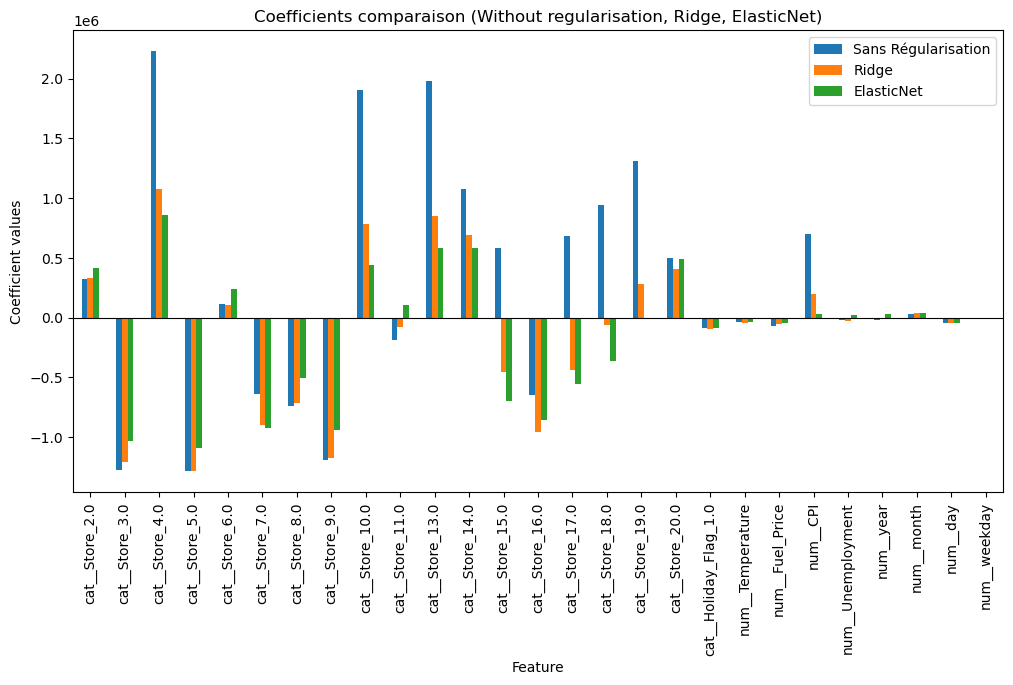

In [116]:
df_coeffs.set_index('Feature').plot(kind='bar', figsize=(12, 6))
plt.axhline(0, color='black', linewidth=0.8)
plt.title("Coefficients comparaison (Without regularisation, Ridge, ElasticNet)")
plt.ylabel("Coefficient values")
plt.legend()
plt.show()

In [115]:
# Compute performance metrics
models = {
    "Linear Regression without regularisation": model,
    "Ridge": grid_search_ridge,
    "ElasticNet": grid_search_elasticnet
}

for name, model in models.items():
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print(f"\n=== {name} ===")
    print(f"R² (train) : {r2_score(Y_train, y_train_pred):.4f}")
    print(f"R² (test)  : {r2_score(Y_test, y_test_pred):.4f}")
    print(f"MSE (train): {mean_squared_error(Y_train, y_train_pred):.2f}")
    print(f"MSE (test) : {mean_squared_error(Y_test, y_test_pred):.2f}")



=== Linear Regression without regularisation ===
R² (train) : 0.9769
R² (test)  : 0.9525
MSE (train): 10413274239.99
MSE (test) : 15707699447.51

=== Ridge ===
R² (train) : 0.9813
R² (test)  : 0.9520
MSE (train): 8431576150.98
MSE (test) : 15860323532.57

=== ElasticNet ===
R² (train) : 0.9769
R² (test)  : 0.9525
MSE (train): 10413274239.99
MSE (test) : 15707699447.51


# Conclusion

In this study, we explored several regression techniques to predict sales, comparing three models: without regularization, Ridge and ElasticNet. Here are the main results obtained:

**Model without regularization:**
* Although performing well on the training data (R² = 0.9820), this model suffers from overfitting, with a significant gap between the training and test results (R² = 0.9432).
* The absence of regularization leads to poor generalization, as shown by the difference in MSE (Mean Square Error) between the training and test sets.

**Ridge Regression:**
* This model showed a significant improvement, with a performance of R² = 0.9520 on the test set, while reducing overfitting compared to the model without regularization.
* Ridge allowed better generalization, although its MSE on the test remains higher than that of ElasticNet.

**ElasticNet:**
* ElasticNet provided very similar results to Ridge, with a performance of R² = 0.9525 on the test data. L1 regularization combined with L2 regularization allowed efficient variable selection and variance control.
* ElasticNet proved to be a good compromise between Lasso (L1) and Ridge (L2) regularization, while maintaining performances close to those of Ridge.

**Key interpretations:**

* Ridge and ElasticNet generally handled overfitting better compared to the model without regularization, showing the importance of regularization to improve model generalization on unobserved data.
* ElasticNet slightly underperformed Ridge in terms of R² in training, but maintained an excellent balance for predicting on the test set.